In this notebook, I will summarize the results of the bootstraps

In [2]:
%run ../scripts/notebook_settings_lean.py
#from horizonplot import horizonplot

/faststorage/project/baboondiversity/people/eriks/baboon_first_analysis/scripts/notebook_settings_lean.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina', 'png')


In [20]:
def globetrotter_parse(path, idfile):
    f = open(path)
    lines = f.readlines()
    # Lines 11 to 16 contain the information for PC1, one-date fit.
    df1, df2 = pd.DataFrame(), pd.DataFrame()
    # I am going to implement it in a "long" format
    i = 0
    # This is done so that the most recent event is fitted in the multiple-dates case
    if lines[0].strip().split()[-1][:-1] == "multiple-dates":
        i += 12
    df1["source"] = lines[12+i].strip().split(" ")[1:]
    df1["sourcetype"] = "source1"
    df1["proportion"] = lines[12+i].split(" ")[0]
    df1["surrogate"] = lines[11+i].strip().split(" ")[1:]
    df2["source"] = lines[14+i].strip().split(" ")[1:]
    df2["sourcetype"] = "source2"
    df2["proportion"] = lines[14+i].split(" ")[0]
    df2["surrogate"] = lines[13+i].strip().split(" ")[1:]
    df = pd.concat([df1, df2])
    df["estimate"] = lines[0].strip().split(" ")[-1][:-1]
    return df

Loading the data - I have varying degrees of files per cluster, so using a flexible loader

In [21]:
step_path = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/"
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "population", "inclusion"])
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")

In [22]:
rundir = "all_autosomes_8_cluster/"
df_l = []
for population in idfile.loc[idfile.inclusion==1].population.unique():
    print(population)
    total_path = step_path+rundir+population+"_"+rundir+"gb.fast.null.main.txt"
    df = globetrotter_parse(total_path, idfile)
    df["population"] = population
    df_l.append(df)
df_8_cluster = pd.concat(df_l)
df_8_cluster = df_8_cluster.astype({"source": float, "proportion": float})

cyno_central
kindae
hamadryas
anubis_tanzania
cyno_western
papio
ursinus
anubis_ethiopia


In [23]:
boot_l = []
for population in idfile.loc[idfile.inclusion==1].population.unique():
    pop_l = []
    for i in range(1,101):
        total_path = step_path+rundir+population+"_"+rundir+"gb{}.fast.null.boot.txt".format(i)
        if os.path.exists(total_path):
            pop_l.append(pd.read_csv(total_path, sep=" "))
    print(population)
    if len(pop_l) > 0:
        pop_df = pd.concat(pop_l)
        pop_df["population"] = population
        print(len(pop_df))
        boot_l.append(pop_df)
boot_df = pd.concat(boot_l)

cyno_central
200
kindae
324
hamadryas
400
anubis_tanzania
130
cyno_western
400
papio
400
ursinus
400
anubis_ethiopia
400


In [24]:
gb_df_l = []
for population in idfile.loc[idfile.inclusion==1].population.unique():
    total_path = step_path+rundir+population+"_"+rundir+"gb.fast.null.main.txt"
    f = open(total_path)
    lines = f.readlines()
    d = {}
    l_3 = lines[3].strip().split(" ")
    l_4 = lines[4].strip().split(" ")
    for i in range(len(l_3)):
        d[l_3[i]] = [l_4[i]]
    df = pd.DataFrame(d)
    df["population"] = population
    gb_df_l.append(df)
gb_df = pd.concat(gb_df_l)

In [25]:
gb_df

,gen.1date,proportion.source1,maxR2fit.1date,fit.quality.1event,fit.quality.2events,bestmatch.event1.source1,bestmatch.event1.source2,proportion.event2.source1,bestmatch.event2.source1,bestmatch.event2.source2,population
0,55.1451223617848,0.15,0.211650922081559,0.997771116514533,0.998858140965931,anubis_tanzania,anubis_tanzania,0.05,anubis_tanzania,anubis_tanzania,cyno_central
0,43.9774094294234,0.19,0.911142176913912,0.999731376095611,0.999818701060377,ursinus,cyno_western,0.13,cyno_western,cyno_western,kindae
0,27.6928351400697,0.04,0.453467460282897,0.990526949529621,0.99170365740865,anubis_tanzania,anubis_ethiopia,0.01,anubis_ethiopia,anubis_ethiopia,hamadryas
0,50.424530534308,0.23,0.890632380025417,0.990841791596105,0.99982669169549,anubis_ethiopia,anubis_ethiopia,0.09,anubis_ethiopia,anubis_ethiopia,anubis_tanzania
0,27.4889440839625,0.43,0.967209770755577,0.948637699337102,0.999791192850136,kindae,anubis_tanzania,0.47,cyno_central,kindae,cyno_western
0,1,0.02,0.104506596789253,0.375442054117623,0.403474725120135,anubis_tanzania,anubis_tanzania,0.02,anubis_tanzania,anubis_tanzania,papio
0,10.5520080566406,0.14,0.899379696679482,0.999367350942782,0.999934627334656,cyno_central,kindae,0.49,kindae,kindae,ursinus
0,75.9306640625,0.15,0.111477996923888,0.942509910864201,0.99410176196867,anubis_tanzania,anubis_tanzania,0.47,anubis_tanzania,anubis_tanzania,anubis_ethiopia


Workflow for generating a table similar to globetrotter results

In [26]:
p_val_l = []
recipient_l = []
conclusion_l = []
median_date_l = []
ce_l = []
for population in idfile.loc[idfile.inclusion==1].population.unique():
    s_df = boot_df.loc[boot_df["population"] == population]
    if len(s_df) >= 50:
        p_val = (sum(s_df["date1.est.boot"] <= 1) +  sum(s_df["date1.est.boot"] >= 400))/len(s_df)
        print(p_val, population)
        print(s_df["date1.est.boot"].quantile(0.025), s_df["date1.est.boot"].quantile(0.975))
        print(s_df["date1.est.boot"].quantile(0.5))
        median_date_l.append(str(s_df["date1.est.boot"].quantile(0.5))[:4])
        ce_l.append(str(s_df["date1.est.boot"].quantile(0.025))[:5]+"-"+str(s_df["date1.est.boot"].quantile(0.975))[:5])
        if p_val < 0.01:
            p_val_l.append("< 0.01")
        else:
            p_val_l.append(p_val)
        recipient_l.append(population)
        if p_val > 0.05:
            conclusion_l.append("No admixture event well-supported")
        else:
            conclusion_l.append("Admixture event detected")

0.035 cyno_central
1.0 93.70116700000001
42.148115000000004
0.0 kindae
27.1160645 64.62793950000001
41.161705
0.0 hamadryas
12.413981249999999 75.99889749999994
32.82073
0.0 anubis_tanzania
37.318838500000005 70.88011149999997
55.317735
0.0 cyno_western
18.53222175 34.65747275
26.398114999999997
0.765 papio
1.0 111.60286499999997
1.0
0.0175 ursinus
1.9182643250000002 23.258525499999998
10.552015
0.2475 anubis_ethiopia
1.0 181.0577
10.87539


In [27]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
name_order = ['Olive Gog', 'Olive South', 'Yellow East', 'Yellow West',
       'Hamadryas', 'Kinda', 'Guinea', 'Chacma']
i_order = sorted(boot_df["population"].unique())
p_map = {}
for i in range(len(i_order)):
    p_map[i_order[i]] = name_order[i]

In [28]:
p_map

{'anubis_ethiopia': 'Olive Gog',
 'anubis_tanzania': 'Olive South',
 'cyno_central': 'Yellow East',
 'cyno_western': 'Yellow West',
 'hamadryas': 'Hamadryas',
 'kindae': 'Kinda',
 'papio': 'Guinea',
 'ursinus': 'Chacma'}

In [29]:
conclusion_df_8 = pd.DataFrame({"P-value": p_val_l, "Population": recipient_l, "Median generations ago": median_date_l,
                                 "95% CE of generation time": ce_l, "Conclusion": conclusion_l})
conclusion_df_8["Population"] = conclusion_df_8.Population.map(p_map)
conclusion_df_8.to_excel("../results/globetrotter_8_pvalues.xlsx")

In [30]:
conclusion_df_8.to_excel("../results/globetrotter_8_pvalues.xlsx", index=False)

In [31]:
conclusion_df_8

,P-value,Population,Median generations ago,95% CE of generation time,Conclusion
0,0.035,Yellow East,42.1,1.0-93.70,Admixture event detected
1,< 0.01,Kinda,41.1,27.11-64.62,Admixture event detected
2,< 0.01,Hamadryas,32.8,12.41-75.99,Admixture event detected
3,< 0.01,Olive South,55.3,37.31-70.88,Admixture event detected
4,< 0.01,Yellow West,26.3,18.53-34.65,Admixture event detected
5,0.765,Guinea,1.0,1.0-111.6,No admixture event well-supported
6,0.0175,Chacma,10.5,1.918-23.25,Admixture event detected
7,0.2475,Olive Gog,10.8,1.0-181.0,No admixture event well-supported


<AxesSubplot:xlabel='date1.est.boot', ylabel='Count'>

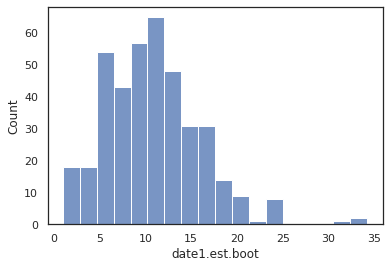

In [13]:
s_df = boot_df.loc[boot_df["population"] == "ursinus"]
sns.histplot(s_df["date1.est.boot"])

In [14]:
s_df

,bootstrap.num,date1.est.boot,maxR2fit.1date.boot,maxScore.2events.boot,population
0,1,1.422619,0.867227,0.117768,ursinus
1,2,8.171973,0.807833,0.097107,ursinus
2,3,4.812952,0.737672,0.098047,ursinus
3,4,6.908099,0.865645,0.074402,ursinus
0,1,13.848070,0.778554,0.285297,ursinus
...,...,...,...,...,...
3,4,12.156640,0.803855,0.052961,ursinus
0,1,9.877173,0.912172,0.221035,ursinus
1,2,10.689940,0.917002,0.248000,ursinus
2,3,16.603370,0.798293,0.315667,ursinus


In [15]:
step_path = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/"
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_14_cluster.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "population", "inclusion"])
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")

In [16]:
rundir = "all_autosomes_14_cluster/"
df_l = []
for population in idfile.loc[idfile.inclusion==1].population.unique():
    print(population)
    total_path = step_path+rundir+population+"_"+rundir+"gb.fast.null.main.txt"
    df = globetrotter_parse(total_path, idfile)
    df["population"] = population
    df_l.append(df)
df_8_cluster = pd.concat(df_l)
df_8_cluster = df_8_cluster.astype({"source": float, "proportion": float})

cyno_mikumi
kindae
hamadryas
anubis_serengeti
anubis_na
cyno_ruaha
anubis_gombe
cyno_us
cyno_western
anubis_manyara
anubis_tarangire
papio
ursinus
anubis_ethiopia


In [17]:
boot_l = []
for population in idfile.loc[idfile.inclusion==1].population.unique():
    pop_l = []
    for i in range(1,101):
        total_path = step_path+rundir+population+"_"+rundir+"gb{}.fast.null.boot.txt".format(i)
        if os.path.exists(total_path):
            pop_l.append(pd.read_csv(total_path, sep=" "))
    print(population)
    if len(pop_l) > 0:
        pop_df = pd.concat(pop_l)
        pop_df["population"] = population
        print(len(pop_df))
        boot_l.append(pop_df)
boot_df_14 = pd.concat(boot_l)

cyno_mikumi
138
kindae
149
hamadryas
126
anubis_serengeti
114
anubis_na
100
cyno_ruaha
110
anubis_gombe
100
cyno_us
100
cyno_western
100
anubis_manyara
100
anubis_tarangire
100
papio
100
ursinus
100
anubis_ethiopia
100


In [18]:
gb_df_l = []
for population in idfile.loc[idfile.inclusion==1].population.unique():
    total_path = step_path+rundir+population+"_"+rundir+"gb.fast.null.main.txt"
    f = open(total_path)
    lines = f.readlines()
    d = {}
    l_3 = lines[3].strip().split(" ")
    l_4 = lines[4].strip().split(" ")
    for i in range(len(l_3)):
        d[l_3[i]] = [l_4[i]]
    df = pd.DataFrame(d)
    df["population"] = population
    gb_df_l.append(df)
gb_df_14 = pd.concat(gb_df_l)

In [19]:
p_val_l = []
recipient_l = []
conclusion_l = []
median_date_l = []
ce_l = []
for population in idfile.loc[idfile.inclusion==1].population.unique():
    s_df = boot_df_14.loc[boot_df_14["population"] == population]
    if len(s_df) >= 50:
        p_val = (sum(s_df["date1.est.boot"] <= 1) +  sum(s_df["date1.est.boot"] >= 400))/len(s_df)
        print(p_val, population)
        print(s_df["date1.est.boot"].quantile(0.025), s_df["date1.est.boot"].quantile(0.975))
        print(s_df["date1.est.boot"].quantile(0.5))
        median_date_l.append(str(s_df["date1.est.boot"].quantile(0.5))[:5])
        ce_l.append(str(s_df["date1.est.boot"].quantile(0.025))[:5]+"-"+str(s_df["date1.est.boot"].quantile(0.975))[:5])
        if p_val < 0.01:
            p_val_l.append("< 0.01")
        else:
            p_val_l.append(p_val)
        recipient_l.append(population)
        if p_val > 0.01:
            conclusion_l.append("No admixture event well-supported")
        else:
            conclusion_l.append("Admixture event detected")

0.0 cyno_mikumi
22.00456775 62.16262024999999
40.85601
0.0 kindae
23.374271 59.653629999999964
38.82998
0.0 hamadryas
9.473349 91.03711
27.602815
0.0 anubis_serengeti
39.681576500000006 187.59355
94.54736
0.0 anubis_na
13.29441025 53.73038299999999
33.970955000000004
0.0 cyno_ruaha
30.584913 67.456043
45.001395
0.0 anubis_gombe
19.245566750000002 152.4272499999999
76.46607
0.0 cyno_us
24.36802725 69.94637099999998
44.073494999999994
0.0 cyno_western
18.7509555 34.83760724999999
26.748205
0.0 anubis_manyara
55.919563249999996 127.04457
91.695925
0.0 anubis_tarangire
38.74681425 59.26644924999999
45.99777
0.8 papio
1.0 33.0193
1.0
0.08 ursinus
1.0 14.584596999999995
5.6184615
0.3 anubis_ethiopia
1.0 79.71419824999981
7.961914500000001


In [20]:
p_map["anubis_serengeti"] = "Serengeti"
p_map["anubis_na"] = "Ngorongoro and Arusha"
p_map["anubis_manyara"] = "Lake Manyara"
p_map["anubis_tarangire"] = "Tarangire"
p_map["anubis_gombe"] = "Gombe"
p_map["cyno_us"] = "Udzungwa and Selous"
p_map["cyno_ruaha"] = "Ruaha"
p_map["cyno_mikumi"] = "Mikumi"
p_map["cyno_ruaha"] = "Ruaha"

In [21]:
p_map

{'anubis_ethiopia': 'Olive Gog',
 'anubis_tanzania': 'Olive South',
 'cyno_central': 'Yellow East',
 'cyno_western': 'Yellow West',
 'hamadryas': 'Hamadryas',
 'kindae': 'Kinda',
 'papio': 'Guinea',
 'ursinus': 'Chacma',
 'anubis_serengeti': 'Serengeti',
 'anubis_na': 'Ngorongoro and Arusha',
 'anubis_manyara': 'Lake Manyara',
 'anubis_tarangire': 'Tarangire',
 'anubis_gombe': 'Gombe',
 'cyno_us': 'Udzungwa and Selous',
 'cyno_ruaha': 'Ruaha',
 'cyno_mikumi': 'Mikumi'}

In [22]:
conclusion_df_14 = pd.DataFrame({"P-value": p_val_l, "Population": recipient_l, "Median generations ago": median_date_l,
                                 "95% CE of generation time": ce_l, "Conclusion": conclusion_l})
conclusion_df_14["Population"] = conclusion_df_14.Population.map(p_map)
conclusion_df_14.to_excel("../results/globetrotter_14_pvalues.xlsx")
conclusion_df_14

,P-value,Population,Median generations ago,95% CE of generation time,Conclusion
0,< 0.01,Mikumi,40.85,22.00-62.16,Admixture event detected
1,< 0.01,Kinda,38.82,23.37-59.65,Admixture event detected
2,< 0.01,Hamadryas,27.60,9.473-91.03,Admixture event detected
3,< 0.01,Serengeti,94.54,39.68-187.5,Admixture event detected
4,< 0.01,Ngorongoro and Arusha,33.97,13.29-53.73,Admixture event detected
5,< 0.01,Ruaha,45.00,30.58-67.45,Admixture event detected
6,< 0.01,Gombe,76.46,19.24-152.4,Admixture event detected
7,< 0.01,Udzungwa and Selous,44.07,24.36-69.94,Admixture event detected
8,< 0.01,Yellow West,26.74,18.75-34.83,Admixture event detected
9,< 0.01,Lake Manyara,91.69,55.91-127.0,Admixture event detected


In [23]:
conclusion_df_14.to_excel("../results/globetrotter_14_pvalues.xlsx", index=False)

<AxesSubplot:xlabel='date1.est.boot', ylabel='Count'>

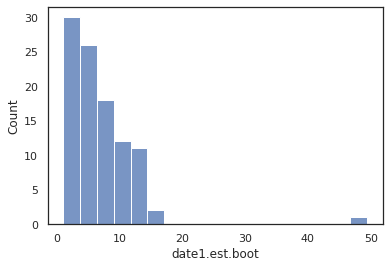

In [24]:
s_df = boot_df_14.loc[boot_df_14["population"] == "ursinus"]
sns.histplot(s_df["date1.est.boot"])

In [25]:
s_df

,bootstrap.num,date1.est.boot,maxR2fit.1date.boot,maxScore.2events.boot,population
0,1,8.132330,0.710577,0.079146,ursinus
1,2,5.085353,0.857889,0.135829,ursinus
2,3,6.243448,0.824951,0.155487,ursinus
3,4,5.602536,0.891429,0.227116,ursinus
0,1,9.643188,0.891813,0.169578,ursinus
...,...,...,...,...,...
3,4,6.440409,0.881151,0.307414,ursinus
0,1,6.509768,0.846147,0.107106,ursinus
1,2,7.498557,0.751222,0.225901,ursinus
2,3,5.137945,0.781561,0.148119,ursinus


In [26]:
gb_df_14

,gen.1date,proportion.source1,maxR2fit.1date,fit.quality.1event,fit.quality.2events,bestmatch.event1.source1,bestmatch.event1.source2,proportion.event2.source1,bestmatch.event2.source1,bestmatch.event2.source2,population
0,46.8665134972882,0.06,0.493232646109146,0.999943552027479,0.999943552027479,cyno_ruaha,cyno_us,NA,NA,NA,cyno_mikumi
0,41.0225766365061,0.47,0.916724670331156,0.999729649197495,0.999902741225579,cyno_western,cyno_western,0.46,cyno_western,cyno_western,kindae
0,15.2047014280804,0.09,0.392356314509719,0.996619286706518,0.99714677104266,anubis_ethiopia,anubis_ethiopia,0.05,anubis_ethiopia,anubis_ethiopia,hamadryas
0,111.9072265625,0.37,0.369376801380838,0.896116048748649,0.998141661840877,anubis_na,anubis_gombe,0.28,anubis_na,anubis_na,anubis_serengeti
0,32.9695964703091,0.14,0.844608849225618,0.86065385125622,0.999844799386854,anubis_serengeti,anubis_manyara,0.24,anubis_manyara,anubis_manyara,anubis_na
0,45.3321649855708,0.17,0.87313947180227,0.990913885549344,0.999996794146115,cyno_mikumi,cyno_us,0.32,cyno_mikumi,cyno_us,cyno_ruaha
0,84.551025390625,0.37,0.835829898051654,0.998827813630796,0.999847156369418,anubis_serengeti,anubis_serengeti,0.44,anubis_serengeti,anubis_serengeti,anubis_gombe
0,45.7622871109342,0.16,0.825453290041839,0.999980264613503,1,cyno_mikumi,cyno_mikumi,0.17,cyno_mikumi,cyno_mikumi,cyno_us
0,28.493175691986,0.21,0.970041977960981,0.945903573633737,0.999698608117965,anubis_gombe,kindae,0.34,kindae,kindae,cyno_western
0,88.890625,0.21,0.617865210566357,0.791524138674711,1,anubis_tarangire,anubis_na,0.09,anubis_serengeti,anubis_na,anubis_manyara


In [27]:
s_df["date1.est.boot"].quantile(0.025), s_df["date1.est.boot"].quantile(0.975)

(1.0, 14.584596999999995)